In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import pickle

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location
from scripts.analyze_bogota import summary_stats, filter_and_home_assign

np.random.seed(42)
pd.set_option('display.max_columns', 999)

# Loading data

(If you have access to the pickled data files, begin running cells at the cell that reads `### PICKLE FILE ###`)

In [2]:
# Loading 2015 tweets
bo15 = pd.read_csv('../data/tweets/bo_2015.csv')

In [3]:
# Loading shapefiles
bo_shapefiles = convert_shapefile_crs(
    gpd.read_file('../data/shapefiles/MGN_Seccion_urbana/MGN_Seccion_urbana.shp')
)

# Filtering data and adding tracts

First, we want to filter the data to exclude rare Twitter users (tweet count below median number of tweets/user) and power users (tweet count above 99th percentile of tweets/user). Methodology is as follows:

1. Compute 50th and 99th percentile of tweets/user
1. Select the subset of tweets made by users falling between those bounds
1. Geometrize tweet data by using lat/lon
1. Compute a spatial join between tweets and the tract shapefiles
1. Add datetime information for home location analysis
1. Assign home locations (`home` column) and whether or not tweet is made from home (`is_home` column)

In [4]:
# Original dataset analysis
pct_50, pct_99 = summary_stats(bo15)

4056214 total tweets
150333 unique users

Median number of tweets/user: 4.0 tweets
99th percentile of tweets/user: 378.679999999993 tweets


In [5]:
bo15 = filter_and_home_assign(bo15, bo_shapefiles, pct_50, pct_99)

In [6]:
### PICKLE FILE ###
# protocol=4 for large data files (https://stackoverflow.com/a/56151766)
# with open('../data/bo15.pkl', 'wb') as file:
#     pickle.dump(bo15, file, protocol=4)

with open('../data/bo15.pkl', 'rb') as file:
    bo15 = pickle.load(file)

# Analysis

Before we begin our analysis, it helps to show a visual analysis of where our tweets are located. In the map below, we differentiate between the tweets that are assigned a `codigo` in our spatial join:

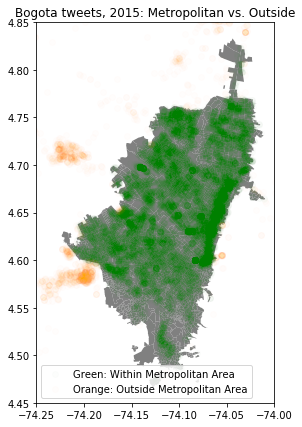

In [7]:
### Plot a 1% sample of 2015 tweets ###
# Green tweets: Joined to a OBJECTID
# Orange tweets: No OBJECTID assigned (NaN)
# Gray (borely visible beneath the blue): Buenos Aires shapefile

fig, ax = plt.subplots(figsize=(10, 7))
bo_shapefiles['geometry'].plot(ax=ax, color='gray')
sample = bo15.sample(frac=0.01, random_state=42)
sample[~sample['OBJECTID'].isnull()].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Within Metropolitan Area')
sample[sample['OBJECTID'].isnull()].plot(ax=ax, marker='o', color='orange', alpha=0.01, label='Orange: Outside Metropolitan Area')
plt.legend()
plt.axis([-74.25, -74, 4.45, 4.85])
plt.title('Bogota tweets, 2015: Metropolitan vs. Outside');

From this, we see that we can use `[~bo15['OBJECTID'].isnull()]` as a filter to select just the tweets in the metropolitan area, which is our area of interest. For all following analyses, we will restrict the population to just the tweets that fall inside the metropolitan area depicted by the shapefile.

Our first summary statistic computes the ratio of tweets that have a home assignment.

In [8]:
num_home_assigned_tweets = (~bo15.loc[~bo15['OBJECTID'].isnull(), 'home'].isnull()).sum()
n_tweets = len(bo15[~bo15['OBJECTID'].isnull()])

print("{}/{} = {:.2%} of tweets have a home assignment.".format(
    num_home_assigned_tweets, n_tweets, num_home_assigned_tweets / n_tweets
))

1337752/2161095 = 61.90% of tweets have a home assignment.


Next, we are interested in the ratio of users that have a home assignment.

In [9]:
num_users_with_home = (~bo15.loc[~bo15['OBJECTID'].isnull()].groupby('u_id')['home'].first().isnull()).sum()
n_users = len(bo15[~bo15['OBJECTID'].isnull()].groupby('u_id'))

print("{}/{} = {:.2%} of users have a home assignment.".format(
    num_users_with_home, n_users, num_users_with_home / n_users
))

13556/69182 = 19.59% of users have a home assignment.


Lastly, we want to know the ratio of tweets that were made from home (i.e. `OBJECTID` and `home` are equal).

In [10]:
num_tweets_from_home = bo15.loc[~bo15['OBJECTID'].isnull(), 'is_home'].sum()

print("{}/{} = {:.2%} of tweets are posted from the home tract.".format(
    num_tweets_from_home, n_tweets, num_tweets_from_home / n_tweets
))

957939/2161095 = 44.33% of tweets are posted from the home tract.


Our analysis concludes with a visual representation of this last information; namely, how are the tweets spread out across the entire metropolitan area of Buenos Aires with respect to residence/nonresidence?

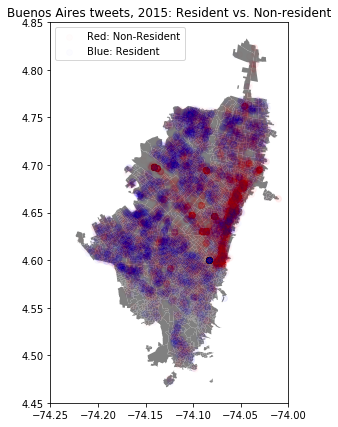

In [11]:
### Plot a 1% sample of 2015 tweets ###
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (borely visible beneath the blue): Buenos Aires shapefile

fig, ax = plt.subplots(figsize=(10, 7))
bo_shapefiles['geometry'].plot(ax=ax, color='gray')
sample = bo15[~bo15['OBJECTID'].isnull()].sample(frac=0.01, random_state=42)
sample[~sample['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
sample[sample['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-74.25, -74, 4.45, 4.85])
plt.title('Buenos Aires tweets, 2015: Resident vs. Non-resident');

# Saving output

For future reference, we save two outputs:

1. Number of tweets + home tweet ratio for each codigo
1. Tweets from the following focus codigos (with some restrictions, specified in code):
    - Parque Patricios
    - Boca

In [12]:
##### 1. Number of tweets + home tweet ratio for each codigo #####
(
    ba12
    .loc[~ba12['codigo'].isnull(), ['codigo', 'is_home']]
    .groupby('codigo')
    .agg([len, np.mean])
    .T.reset_index(drop=True).T
    .rename(columns={0:'count', 1:'home_tweet_ratio'})
).to_csv('../data/ba12_by_codigo.csv')

In [13]:
##### 2. Tweets from focus codigos #####
def save_focus_codigo_data(data, year):
    parque = data[(data['BARRIOS'] == 'PARQUE PATRICIOS') | 
                  (data['codigo'].isin([20041001, 20012905, 20032309]))]
    boca = data[(data['BARRIOS'] == 'BOCA') & (data['codigo'] != 20041801)]
    
    parque.to_csv('../data/ba' + str(year)[-2:] + '_PARQUE_PATRICIOS.csv', index=False)
    boca.to_csv('../data/ba' + str(year)[-2:] + '_BOCA.csv', index=False)
    
save_focus_codigo_data(ba12, 2012)